In [1]:
!pip install circuitsvis python-dotenv --no-deps

  Using cached circuitsvis-1.43.2-py3-none-any.whl.metadata (2.3 kB)
  Using cached python_dotenv-1.0.1-py3-none-any.whl.metadata (23 kB)
Using cached circuitsvis-1.43.2-py3-none-any.whl (1.8 MB)
Using cached python_dotenv-1.0.1-py3-none-any.whl (19 kB)


In [3]:
!pip install -e ../../nnpatch

Obtaining file:///mnt/dlabscratch1/jminder/repositories/nnpatch
  Installing build dependencies ... /

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig
from peft import PeftModel
import einops
from nnsight import NNsight
from nnsight.models.LanguageModel import LanguageModel
import torch
import pandas as pd
import os
from transformer_lens import HookedTransformer
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm, trange
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from collections import defaultdict
import lightning.pytorch as pl
from nnsight import NNsight

from analysis.circuit_utils.visualisation import *
from analysis.circuit_utils.model import *
from analysis.circuit_utils.validation import *
from analysis.circuit_utils.decoding import *
from analysis.circuit_utils.utils import *
from analysis.circuit_utils.metrics import *

from main import load_model_and_tokenizer


device = "cuda:0"


base_args = [
    "--context-weight-format", "float", 
    "--output-dir", "overnight_results", 
    "--source-heads", "o", "q",
    "--topk", "-1",
    "--batch-size", "32",
]
parser = get_default_parser()
parser.add_argument("--dataset-index", default=0, type=int)
parser.add_argument("--n-samples", default=-1, type=int)
parser.add_argument("--output-dir", default="patching_results")
parser.add_argument("--name", default="")
parser.add_argument("--context-info-flow", action="store_true")
parser.add_argument("--prior-info-flow", action="store_true")
parser.add_argument("--context-to-prior", action="store_true")
parser.add_argument("--prior-to-context", action="store_true")
parser.add_argument("--topk", default=10, type=int)
parser.add_argument("--new-few-shots", default=None, type=int)
parser.add_argument("--zero", action="store_true")
parser.add_argument("--no-filtering", action="store_true")
parser.add_argument("--batch-size", default=-1, type=int)
parser.add_argument("--force-model-confidence", action="store_true")
parser.add_argument("--heads", default=["o"], nargs="+")
parser.add_argument("--source-heads", default=["o", "q"], nargs="+")
parser.add_argument("--layer-range", "-LR", default=[0, -1], nargs=2, type=int)
parser.add_argument("--layers", default=None, nargs="+", type=int)

_StoreAction(option_strings=['--layers'], dest='layers', nargs='+', const=None, default=None, type=<class 'int'>, choices=None, required=False, help=None, metavar=None)

In [2]:
args = parser.parse_args(base_args)
PATHS = paths_from_args(args)
PATHS

{'BASE_MODEL': '/dlabscratch1/public/llm_weights/llama3.1_hf/Meta-Llama-3.1-8B-Instruct',
 'MODEL_NAME': 'Meta-Llama-3.1-8B-Instruct-bs8-ga2-NT-cwf_float',
 'DATAROOT': '/mnt/dlabscratch1/jminder/repositories/context-vs-prior-finetuning/data/BaseFakepedia',
 'TRAIN_DATA': '/mnt/dlabscratch1/jminder/repositories/context-vs-prior-finetuning/data/BaseFakepedia/splits/nodup_relpid/train.csv',
 'DATASET_CONFIG_NAME': 'BaseFakepedia_nodup_relpid-ts2048',
 'PEFT_MODEL': '/mnt/dlabscratch1/jminder/repositories/context-vs-prior-finetuning/data/BaseFakepedia/BaseFakepedia_nodup_relpid-ts2048/3/models/Meta-Llama-3.1-8B-Instruct-bs8-ga2-NT-cwf_float/model',
 'MERGED_MODEL': '/mnt/dlabscratch1/jminder/repositories/context-vs-prior-finetuning/data/BaseFakepedia/BaseFakepedia_nodup_relpid-ts2048/3/models/Meta-Llama-3.1-8B-Instruct-bs8-ga2-NT-cwf_float/merged',
 'VAL_DATA_ALL': '/mnt/dlabscratch1/jminder/repositories/context-vs-prior-finetuning/data/BaseFakepedia/splits/nodup_relpid/val.csv',
 'TRAIN_

In [3]:
def get_residuals(nnmodel, tokens, attention_mask):
    residuals = [[] for _ in range(len(nnmodel.model.layers))]

    # batch
    batch_size = 4
    for i in trange(0, len(tokens), batch_size):
        with nnmodel.trace(tokens[i:i+batch_size], attention_mask=attention_mask[i:i+batch_size], validate=False, scan=False):
            for i in range(len(nnmodel.model.layers)):
                residuals[i].append(nnmodel.model.layers[i].output[0][:,-1,:].save())
                
        for i in range(len(nnmodel.model.layers)):
            residuals[i][-1] = residuals[i][-1].value.detach().cpu()
    residuals = torch.stack([torch.cat([r.detach() for r in res]) for res in residuals])
    torch.cuda.empty_cache()
    return residuals


def plot_rank(prior_rank, context_rank, add_args):
    plt_args = parser.parse_args(base_args + add_args)

    #  Creating two heatmaps
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    vmin = min(prior_rank.min(), context_rank.min())
    vmax = max(prior_rank.max(), context_rank.max())

    # PRIOR
    heatmap = ax1.imshow(prior_rank, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
    # Annotating each cell with the decoded token
    for i in range(prior_rank.shape[0]):
        for j in range(prior_rank.shape[1]):
            text = ax1.text(j, i, int(prior_rank[i, j].item()), ha="center", va="center", color="w")

    ax1.invert_yaxis()


    # CONTEXT
    heatmap = ax2.imshow(context_rank, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
    plt.colorbar(heatmap)

    for i in range(context_rank.shape[0]):
        for j in range(context_rank.shape[1]):
            text = ax2.text(j, i, int(context_rank[i, j].item()), ha="center", va="center", color="w")
            
    ax2.invert_yaxis()
    # Adding a colorbar
    LAYERS=32
    # Setting axis labels
    ax1.set_yticks(range(LAYERS), range(LAYERS))
    ax1.set_xticks(range(2), ["Prior Answer", "Context Answer"])
    ax1.set_xlabel("Answer Token")
    ax1.set_ylabel("Layer Number")
    ax1.set_title("Context Weight = 0.0")

    ax2.set_yticks(range(LAYERS), range(LAYERS))
    ax2.set_xticks(range(2), ["Prior Answer", "Context Answer"])
    ax2.set_xlabel("Answer Token")
    ax2.set_ylabel("Layer Number")
    ax2.set_title("Context Weight = 1.0")

    #global title
    plt.suptitle(f"Median Patch Scope Rank Across Layers of Llama-3-8B-Instruct {'FewShot' if not plt_args.finetuned else 'FineTuned'} Model (CWF={plt_args.context_weight_format})")


    plt.show()
    
def plot_prob(prior_prob, context_prob, add_args):
    plt_args = parser.parse_args(base_args + add_args)
    print(plt_args.context_weight_format)
    #  Creating two heatmaps
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    vmin = min(prior_prob.min(), context_prob.min())
    vmax = max(prior_prob.max(), context_prob.max())

    # PRIOR
    heatmap = ax1.imshow(prior_prob, cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
    # Annotating each cell with the decoded token
    for i in range(prior_prob.shape[0]):
        for j in range(prior_prob.shape[1]):
            text = ax1.text(j, i, round(prior_prob[i, j].item(), 3), ha="center", va="center", color="w")

    ax1.invert_yaxis()


    # CONTEXT
    heatmap = ax2.imshow(context_prob, cmap='coolwarm', aspect='auto', vmin=vmin, vmax=vmax)
    plt.colorbar(heatmap)

    for i in range(context_prob.shape[0]):
        for j in range(context_prob.shape[1]):
            text = ax2.text(j, i, round(context_prob[i, j].item(), 3), ha="center", va="center", color="w")
            
    ax2.invert_yaxis()
    # Adding a colorbar
    LAYERS=32
    # Setting axis labels
    ax1.set_yticks(range(LAYERS), range(LAYERS))
    ax1.set_xticks(range(2), ["Prior Answer", "Context Answer"])
    ax1.set_xlabel("Answer Token")
    ax1.set_ylabel("Layer Number")
    ax1.set_title("Context Weight = 0.0")

    ax2.set_yticks(range(LAYERS), range(LAYERS))
    ax2.set_xticks(range(2), ["Prior Answer", "Context Answer"])
    ax2.set_xlabel("Answer Token")
    ax2.set_ylabel("Layer Number")
    ax2.set_title("Context Weight = 1.0")

    #global title
    plt.suptitle(f"Median Patch Scope Rank Across Layers of Llama-3-8B-Instruct {'FewShot' if not plt_args.finetuned else 'FineTuned'} Model (CWF={plt_args.context_weight_format})")


    plt.show()
    
def generate_prob_rank(additional_args):
    args = parser.parse_args(base_args + additional_args)
    PATHS = paths_from_args(args)
    model, tokenizer = load_model_and_tokenizer_from_args(PATHS, args)
    nnmodel = NNsight(model)
    args = parser.parse_args(base_args + additional_args)
    clean_prompt, _, clean_tokens, _, clean_index, _, attention_mask_clean, _ = collect_data(args, PATHS, tokenizer, device)
    prior_prompt_idx = clean_prompt.weight_context == 0.0
    context_prompt_idx = clean_prompt.weight_context == 1.0
    prior_tokens = clean_tokens[prior_prompt_idx]
    context_tokens = clean_tokens[context_prompt_idx]
    prior_attention_mask = attention_mask_clean[prior_prompt_idx]
    context_attention_mask = attention_mask_clean[context_prompt_idx]
    prior_index = clean_index[prior_prompt_idx]
    context_index = clean_index[context_prompt_idx]
    
    prior_residuals = get_residuals(nnmodel, prior_tokens, prior_attention_mask)
    context_residuals = get_residuals(nnmodel, context_tokens, context_attention_mask)
    prior_logits = patch_scope(nnmodel, tokenizer, prior_residuals)
    context_logits = patch_scope(nnmodel, tokenizer, context_residuals)
    
    aggregation = "median"
    pp_rank = get_ranks(prior_logits, prior_index.cpu(), aggregation)
    pc_rank = get_ranks(prior_logits, context_index.cpu(), aggregation)
    cp_rank = get_ranks(context_logits, prior_index.cpu(), aggregation)
    cc_rank = get_ranks(context_logits, context_index.cpu(), aggregation)

    pp_prob = get_probs(prior_logits, prior_index.cpu(), aggregation)
    pc_prob = get_probs(prior_logits, context_index.cpu(), aggregation)
    cp_prob = get_probs(context_logits, prior_index.cpu(), aggregation)
    cc_prob = get_probs(context_logits, context_index.cpu(), aggregation)

    p_rank = torch.cat([pp_rank, pc_rank], dim=1)
    c_rank = torch.cat([cp_rank, cc_rank], dim=1)
    p_prob = torch.cat([pp_prob, pc_prob], dim=1)
    c_prob = torch.cat([cp_prob, cc_prob], dim=1)
    return p_rank, c_rank, p_prob, c_prob

def get_answer_logits(additional_args):
    args = parser.parse_args(base_args + additional_args)
    PATHS = paths_from_args(args)
    model, tokenizer = load_model_and_tokenizer_from_args(PATHS, args)
    nnmodel = NNsight(model)
    args = parser.parse_args(base_args + additional_args)
    clean_prompt, _, clean_tokens, _, clean_index, _, attention_mask_clean, _ = collect_data(args, PATHS, tokenizer, device)
    prior_prompt_idx = clean_prompt.weight_context == 0.0
    context_prompt_idx = clean_prompt.weight_context == 1.0
    prior_tokens = clean_tokens[prior_prompt_idx]
    context_tokens = clean_tokens[context_prompt_idx]
    prior_attention_mask = attention_mask_clean[prior_prompt_idx]
    context_attention_mask = attention_mask_clean[context_prompt_idx]
    prior_index = clean_index[prior_prompt_idx]
    context_index = clean_index[context_prompt_idx]
    

    prior_residuals = get_residuals(nnmodel, prior_tokens, prior_attention_mask)
    context_residuals = get_residuals(nnmodel, context_tokens, context_attention_mask)
    prior_logits = patch_scope(nnmodel, tokenizer, prior_residuals)
    context_logits = patch_scope(nnmodel, tokenizer, context_residuals)
    
    return get_logits(prior_logits, prior_index.cpu()), get_logits(prior_logits, context_index.cpu()), get_logits(context_logits, prior_index.cpu()), get_logits(context_logits, context_index.cpu())

# Finetuned

## CWF FLOAT

In [12]:
add_args = ["--finetuned", "--context-weight-format", "float"]
p_rank, c_rank, p_prob, c_prob = generate_prob_rank(add_args)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2024-07-28 11:15:48.516 | INFO     | analysis.circuit_utils.utils:collect_data:111 - Filtered 98 samples


Loaded model on device cuda:0 with dtype torch.bfloat16.


100%|██████████| 32/32 [00:10<00:00,  3.10it/s]


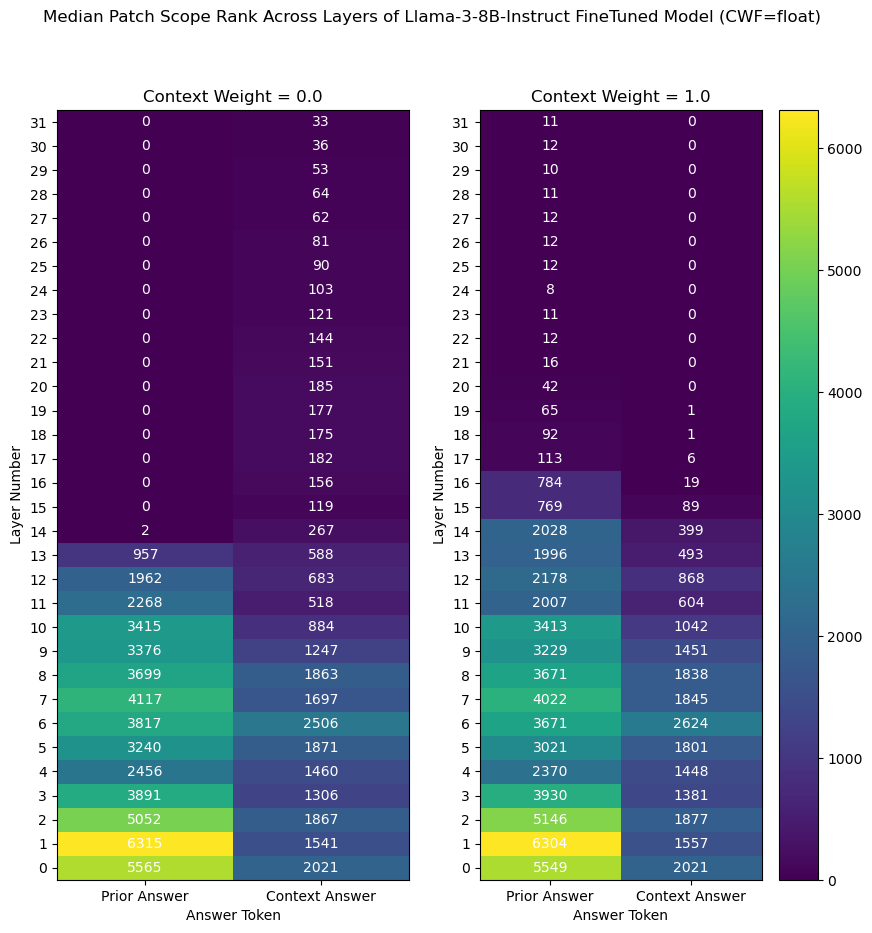

In [13]:
plot_rank(p_rank, c_rank, add_args)

float


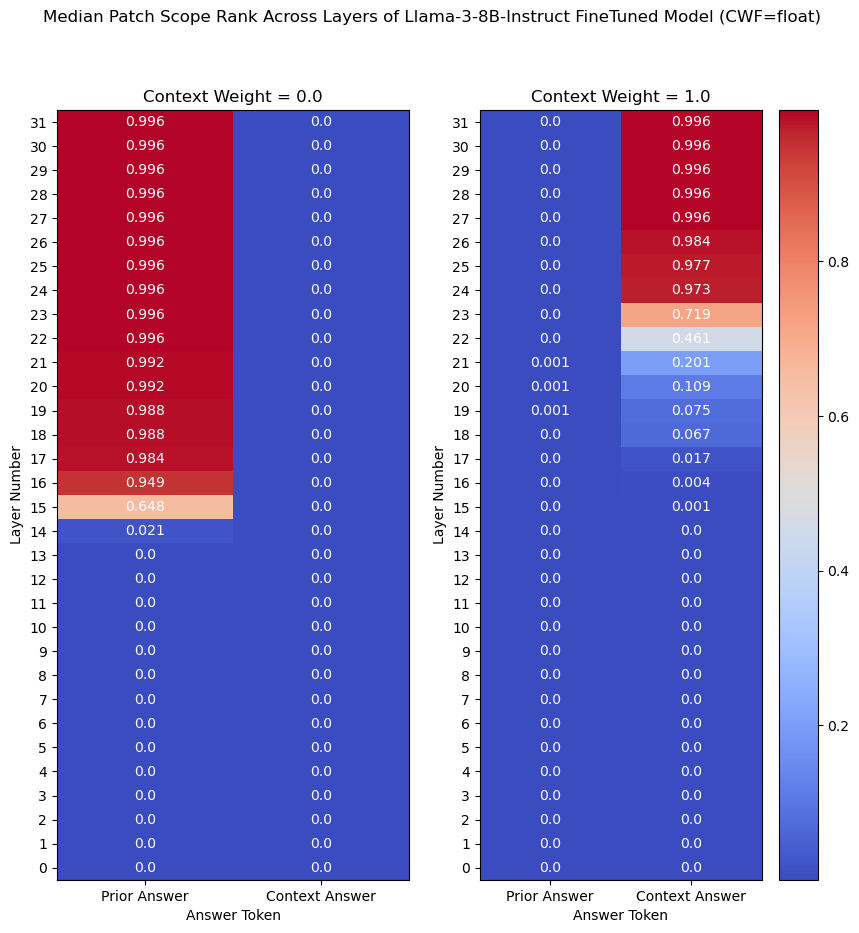

In [14]:
plot_prob(p_prob, c_prob, add_args)

## CWF INSTR

In [15]:
add_args = ["--finetuned", "--context-weight-format", "instruction"]
p_rank, c_rank, p_prob, c_prob = generate_prob_rank(add_args)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2024-07-28 11:17:45.569 | INFO     | analysis.circuit_utils.utils:collect_data:111 - Filtered 34 samples


Loaded model on device cuda:0 with dtype torch.bfloat16.


100%|██████████| 32/32 [00:10<00:00,  2.99it/s]


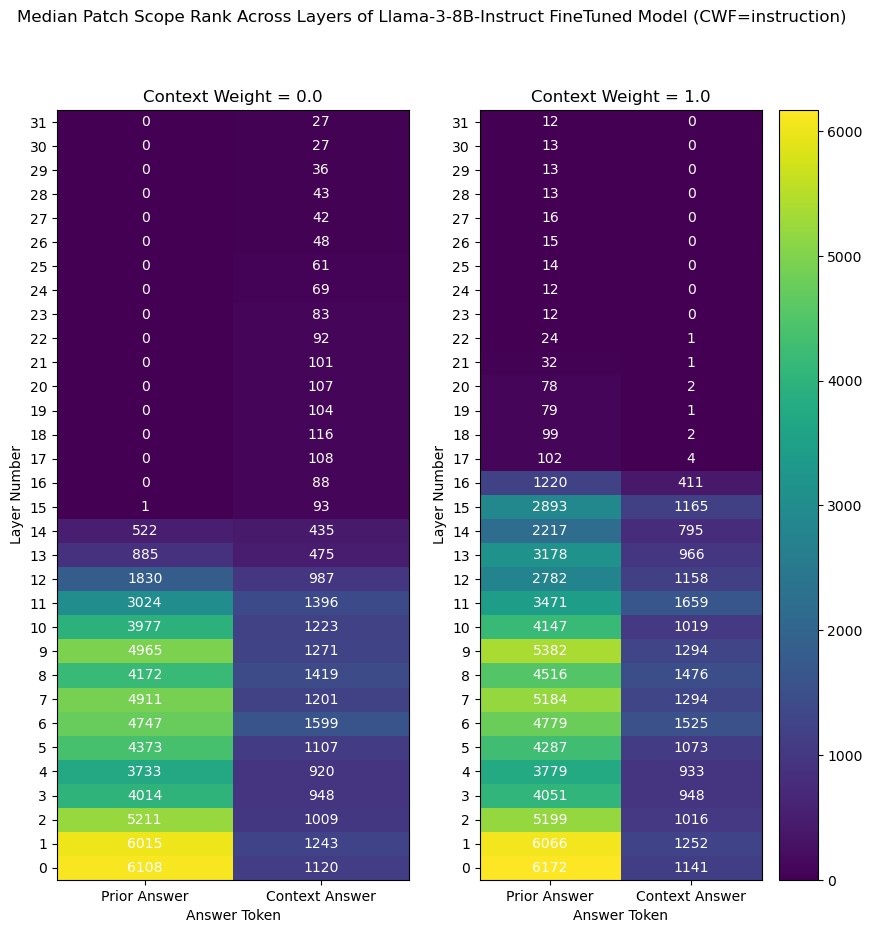

In [16]:
plot_rank(p_rank, c_rank, add_args)

instruction


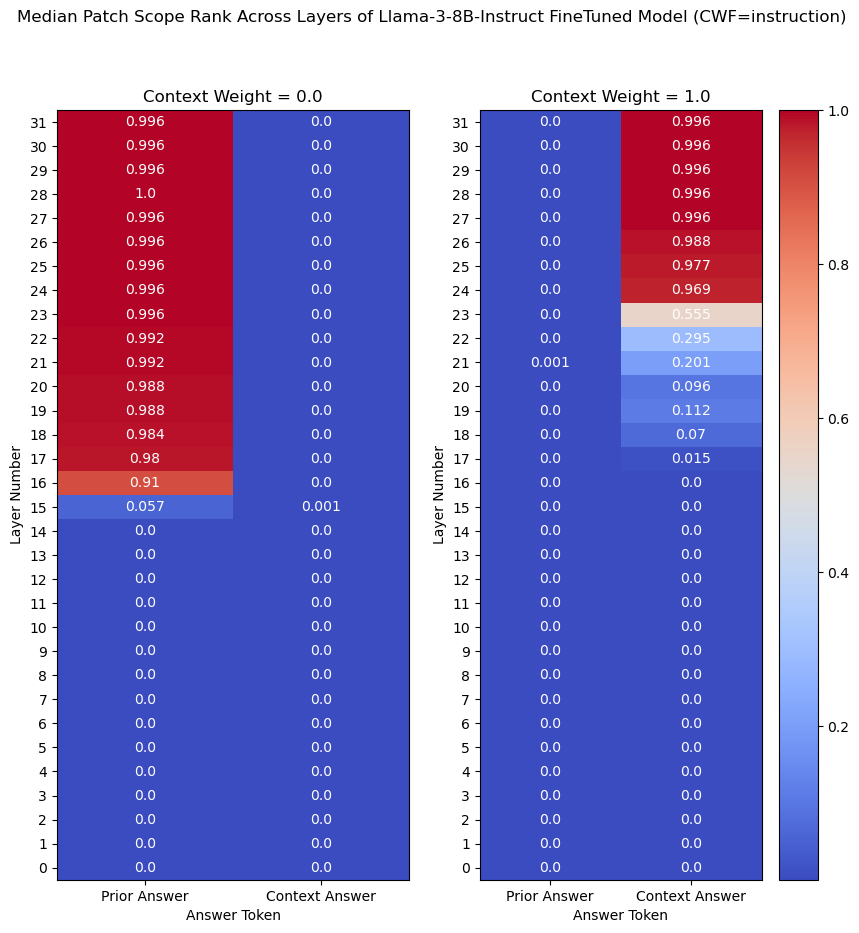

In [17]:
plot_prob(p_prob, c_prob, add_args)

# Few Shot

## CWF FLOAT

In [4]:
add_args = ["--context-weight-format", "float"]
p_rank, c_rank, p_prob, c_prob = generate_prob_rank(add_args)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2024-07-28 10:47:30.626 | INFO     | analysis.circuit_utils.utils:collect_data:111 - Filtered 544 samples


Loaded model on device cuda:0 with dtype torch.bfloat16.


100%|██████████| 32/32 [00:05<00:00,  5.93it/s]


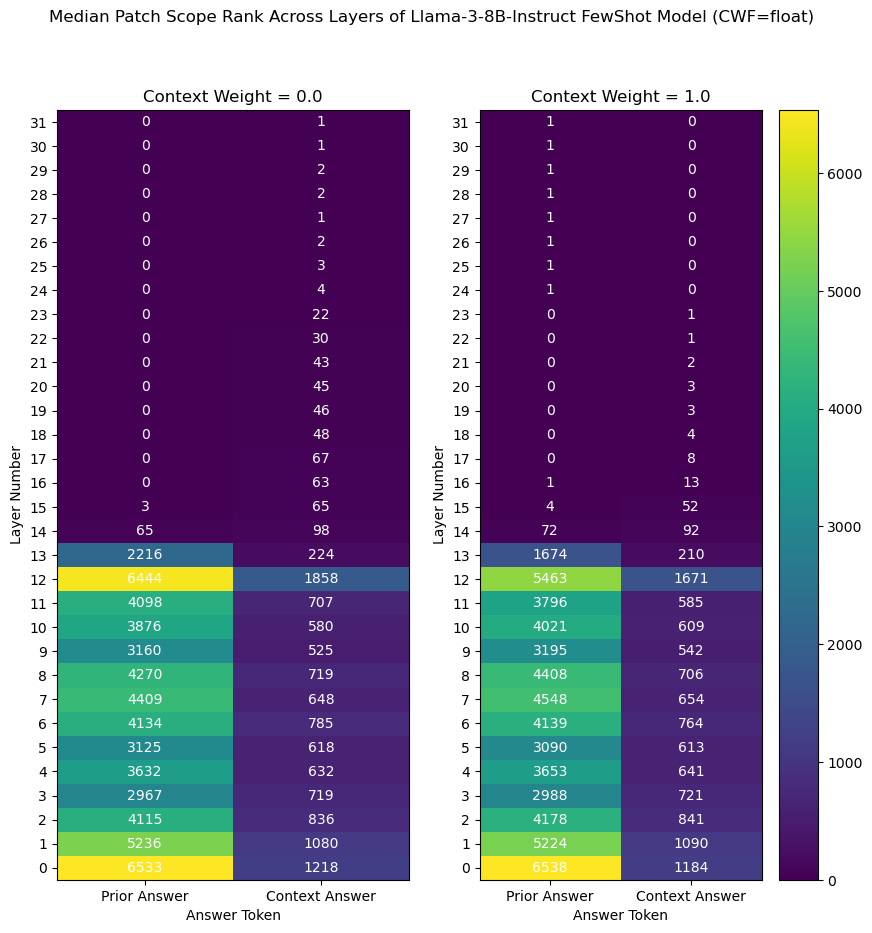

In [7]:
plot_rank(p_rank, c_rank, add_args)

float


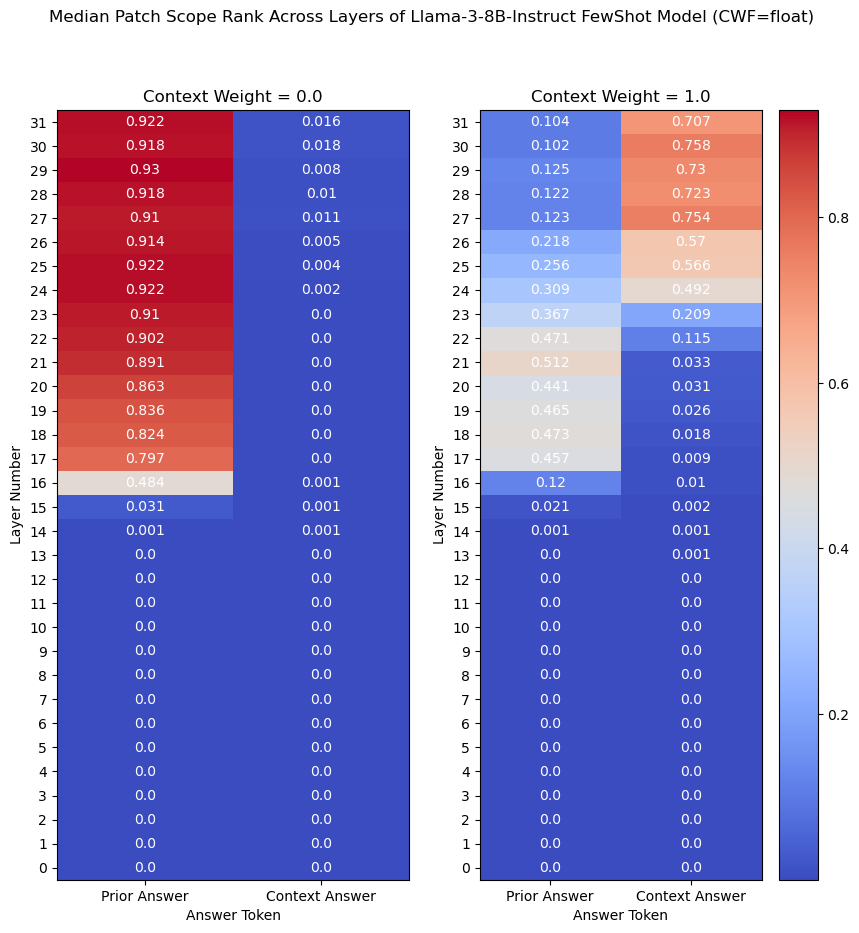

In [8]:
plot_prob(p_prob, c_prob, add_args)

## CWF INSTRUCTION

In [9]:
add_args = ["--context-weight-format", "instruction"]
p_rank, c_rank, p_prob, c_prob = generate_prob_rank(add_args)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2024-07-28 10:53:36.982 | INFO     | analysis.circuit_utils.utils:collect_data:111 - Filtered 160 samples


Loaded model on device cuda:0 with dtype torch.bfloat16.


100%|██████████| 32/32 [00:09<00:00,  3.31it/s]


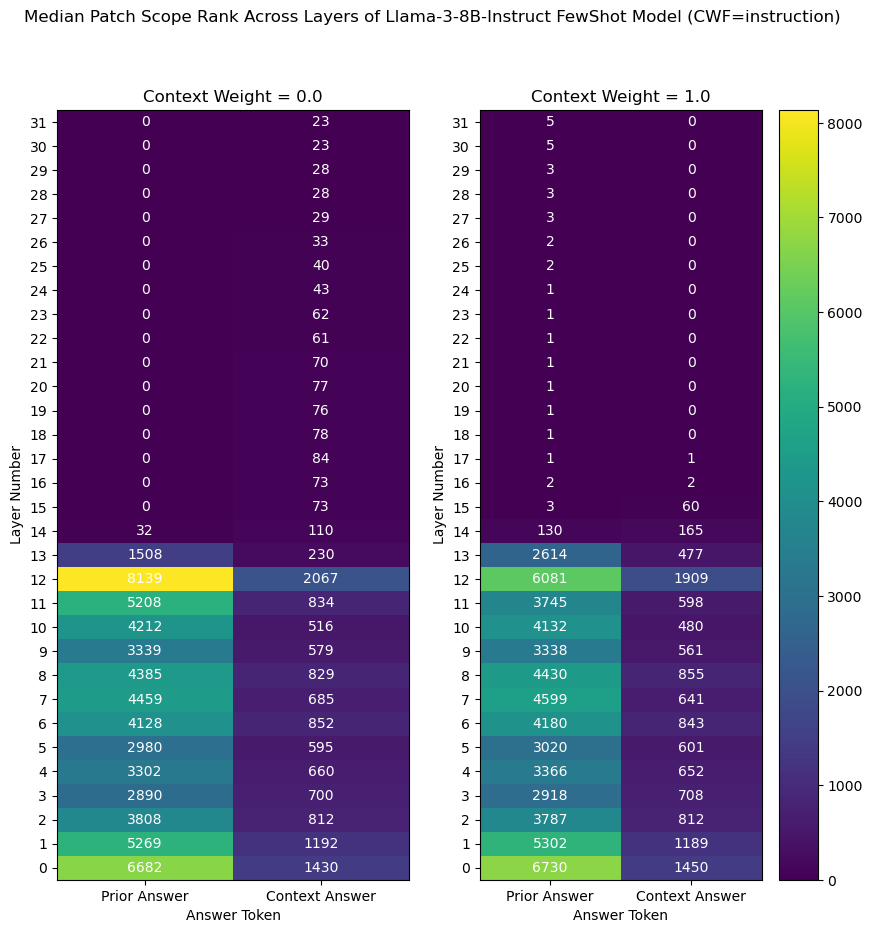

In [10]:
plot_rank(p_rank, c_rank, add_args)

instruction


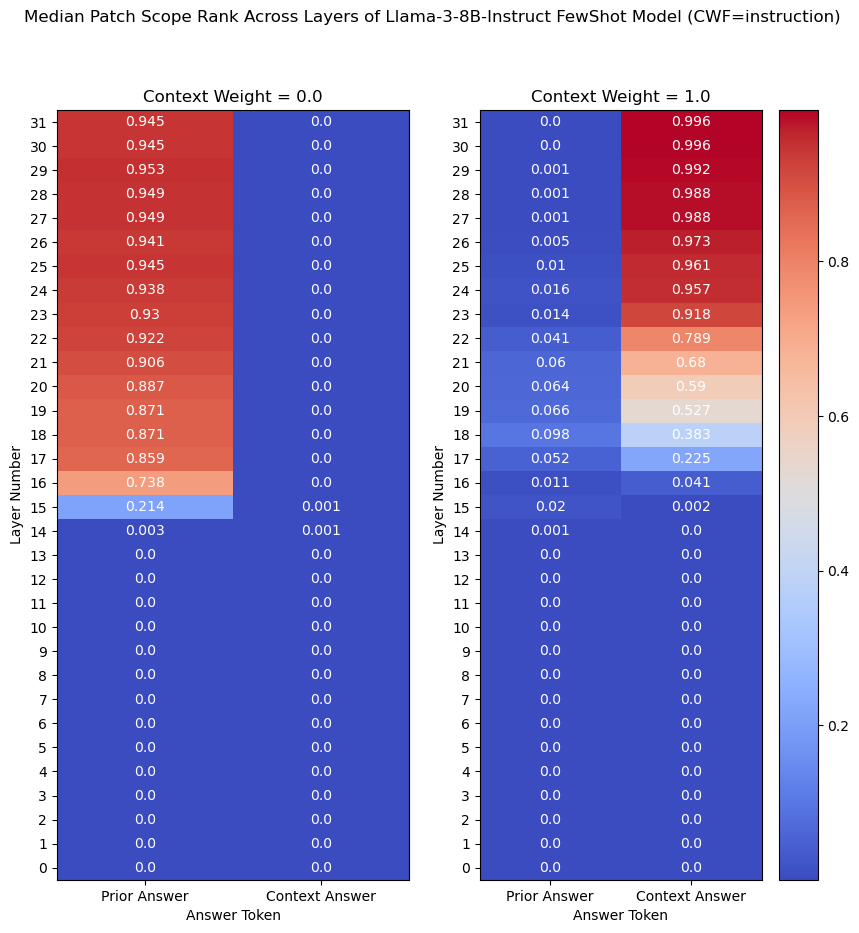

In [11]:
plot_prob(p_prob, c_prob, add_args)

# Quantitative

In [4]:
RESULTS = {}

In [5]:
add_args = ["--context-weight-format", "instruction"]
pp_logits, pc_logits, cp_logits, cc_logits = get_answer_logits(add_args)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2024-07-28 12:12:52.207 | INFO     | analysis.circuit_utils.utils:collect_data:111 - Filtered 160 samples


Loaded model on device cuda:0 with dtype torch.bfloat16.


100%|██████████| 32/32 [00:09<00:00,  3.36it/s]


torch.Size([32, 420, 128256]) torch.Size([420])
torch.Size([32, 420, 128256]) torch.Size([420])
torch.Size([32, 420, 128256]) torch.Size([420])
torch.Size([32, 420, 128256]) torch.Size([420])


In [6]:
RESULTS["FS-I"] = (pp_logits, pc_logits, cp_logits, cc_logits)

add_args = ["--context-weight-format", "float"]
pp_logits, pc_logits, cp_logits, cc_logits = get_answer_logits(add_args)
RESULTS["FS-F"] = (pp_logits, pc_logits, cp_logits, cc_logits)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2024-07-28 12:15:46.469 | INFO     | analysis.circuit_utils.utils:collect_data:111 - Filtered 544 samples


Loaded model on device cuda:0 with dtype torch.bfloat16.


100%|██████████| 32/32 [00:05<00:00,  5.96it/s]


torch.Size([32, 228, 128256]) torch.Size([228])
torch.Size([32, 228, 128256]) torch.Size([228])
torch.Size([32, 228, 128256]) torch.Size([228])
torch.Size([32, 228, 128256]) torch.Size([228])


In [7]:
add_args = ["--finetuned", "--context-weight-format", "instruction"]
pp_logits, pc_logits, cp_logits, cc_logits = get_answer_logits(add_args)
RESULTS["FT-I"] = (pp_logits, pc_logits, cp_logits, cc_logits)

add_args = ["--finetuned", "--context-weight-format", "float"]
pp_logits, pc_logits, cp_logits, cc_logits = get_answer_logits(add_args)
RESULTS["FT-F"] = (pp_logits, pc_logits, cp_logits, cc_logits)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2024-07-28 12:17:19.759 | INFO     | analysis.circuit_utils.utils:collect_data:111 - Filtered 34 samples


Loaded model on device cuda:0 with dtype torch.bfloat16.


100%|██████████| 32/32 [00:10<00:00,  2.97it/s]


torch.Size([32, 483, 128256]) torch.Size([483])
torch.Size([32, 483, 128256]) torch.Size([483])
torch.Size([32, 483, 128256]) torch.Size([483])
torch.Size([32, 483, 128256]) torch.Size([483])


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2024-07-28 12:18:18.211 | INFO     | analysis.circuit_utils.utils:collect_data:111 - Filtered 98 samples


Loaded model on device cuda:0 with dtype torch.bfloat16.


100%|██████████| 32/32 [00:10<00:00,  3.16it/s]


torch.Size([32, 451, 128256]) torch.Size([451])
torch.Size([32, 451, 128256]) torch.Size([451])
torch.Size([32, 451, 128256]) torch.Size([451])
torch.Size([32, 451, 128256]) torch.Size([451])


# Baseline

In [29]:
def ioi_baseline():
    args = parser.parse_args(base_args)

    model, tokenizer = load_model_and_tokenizer_from_args(PATHS, args)

    prompts = [
        "When John and Mary went to the shops, John gave the bag to",
        "When John and Mary went to the shops, Mary gave the bag to",
        "When Tom and James went to the park, James gave the ball to",
        "When Tom and James went to the park, Tom gave the ball to",
        "When Dan and Sid went to the shops, Sid gave an apple to",
        "When Dan and Sid went to the shops, Dan gave an apple to",
        "After Martin and Amy went to the park, Amy gave a drink to",
        "After Martin and Amy went to the park, Martin gave a drink to",
    ]

    answers = [
        (" Mary", " John"),
        (" John", " Mary"),
        (" Tom", " James"),
        (" James", " Tom"),
        (" Dan", " Sid"),
        (" Sid", " Dan"),
        (" Martin", " Amy"),
        (" Amy", " Martin"),
    ]

    tokenizer.padding_side = "left"
    clean_tokens = tokenizer(prompts, return_tensors="pt")
    attention_mask_clean = clean_tokens["attention_mask"]
    clean_tokens = clean_tokens["input_ids"]
    clean_tokens = clean_tokens[
        [(i + 1 if i % 2 == 0 else i - 1) for i in range(len(clean_tokens))]
    ]
    attention_mask_corrupted = attention_mask_clean[
        [(i + 1 if i % 2 == 0 else i - 1) for i in range(len(clean_tokens))]
    ]

    answer_token_indices = torch.tensor(
        [
            [tokenizer(answers[i][j])["input_ids"][0] for j in range(2)]
            for i in range(len(answers))
        ]
    )

    nnmodel = NNsight(model)

    prior_residuals = get_residuals(nnmodel, clean_tokens, attention_mask_clean)
    context_residuals = get_residuals(nnmodel, clean_tokens, attention_mask_corrupted)
    prior_logits = patch_scope(nnmodel, tokenizer, prior_residuals)
    context_logits = patch_scope(nnmodel, tokenizer, context_residuals)

    prior_index = answer_token_indices[:, 0] 
    context_index = answer_token_indices[:, 1] 
    return get_logits(prior_logits, prior_index.cpu()), get_logits(prior_logits, context_index.cpu()), get_logits(context_logits, prior_index.cpu()), get_logits(context_logits, context_index.cpu())

def zero_shot_baseline(cwf):
    return get_answer_logits(["--shots", "0", "--no-filtering", "--context-weight-format", cwf])

In [30]:
RESULTS["IOI"] = ioi_baseline()
RESULTS["ZS-I"] = zero_shot_baseline("instruction")
RESULTS["ZS-F"] = zero_shot_baseline("float")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded model on device cuda:0 with dtype torch.bfloat16.


100%|██████████| 32/32 [00:01<00:00, 31.56it/s]


torch.Size([32, 8, 128256]) torch.Size([8])
torch.Size([32, 8, 128256]) torch.Size([8])
torch.Size([32, 8, 128256]) torch.Size([8])
torch.Size([32, 8, 128256]) torch.Size([8])


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded model on device cuda:0 with dtype torch.bfloat16.


100%|██████████| 32/32 [00:11<00:00,  2.69it/s]


torch.Size([32, 500, 128256]) torch.Size([500])
torch.Size([32, 500, 128256]) torch.Size([500])
torch.Size([32, 500, 128256]) torch.Size([500])
torch.Size([32, 500, 128256]) torch.Size([500])


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded model on device cuda:0 with dtype torch.bfloat16.


100%|██████████| 32/32 [00:11<00:00,  2.70it/s]


torch.Size([32, 500, 128256]) torch.Size([500])
torch.Size([32, 500, 128256]) torch.Size([500])
torch.Size([32, 500, 128256]) torch.Size([500])
torch.Size([32, 500, 128256]) torch.Size([500])


# Plot Results

In [45]:
keys = list(RESULTS.keys())
combs = [(keys[i], keys[j]) for i in range(len(keys)) for j in range(i+1, len(keys))]

similarity_matrix_cos = np.zeros((len(keys), len(keys)))
similarity_matrix_auc = np.zeros((len(keys), len(keys)))
order = ["FS-I", "FS-F", "FT-I", "FT-F", "ZS-I", "ZS-F", "IOI"]
for comb in combs:
    a = torch.stack([RESULTS[comb[0]][0], RESULTS[comb[0]][1], RESULTS[comb[0]][2], RESULTS[comb[0]][3]], dim=0)
    b = torch.stack([RESULTS[comb[1]][0], RESULTS[comb[1]][1], RESULTS[comb[1]][2], RESULTS[comb[1]][3]], dim=0)
    # median reduce
    a = a.median(dim=-1).values
    b = b.median(dim=-1).values
    
    print(comb, cosine(a, b), iou_auc(a, b))
    similarity_matrix_cos[order.index(comb[0]), order.index(comb[1])] = cosine(a, b)
    similarity_matrix_cos[order.index(comb[1]), order.index(comb[0])] = cosine(a, b)
    similarity_matrix_auc[order.index(comb[0]), order.index(comb[1])] = iou_auc(a, b)
    similarity_matrix_auc[order.index(comb[1]), order.index(comb[0])] = iou_auc(a, b)
    baseline_args = []
    
# for key in RESULTS:
#     a = torch.stack([RESULTS[key][0], RESULTS[key][1], RESULTS[key][2], RESULTS[key][3]], dim=0)
#     a = a.median(dim=-1).values
    
#     similarity_matrix_auc[order.index(key), order.index(key)] = iou_auc(a, a)
#     similarity_matrix_cos[order.index(key), order.index(key)] = cosine(a, a)


('FS-I', 'FS-F') 0.99609375 76.38574856510273
('FS-I', 'FT-I') 0.984375 80.5685404159965
('FS-I', 'FT-F') 0.98046875 75.66783430760296
('FS-I', 'IOI') 0.9375 60.56701997319173
('FS-I', 'ZS-I') 0.9765625 75.13637845704439
('FS-I', 'ZS-F') 0.9609375 67.72491616424294
('FS-F', 'FT-I') 0.96875 77.89520230574269
('FS-F', 'FT-F') 0.97265625 80.66802105982296
('FS-F', 'IOI') 0.953125 60.794333983860945
('FS-F', 'ZS-I') 0.97265625 68.73488119247907
('FS-F', 'ZS-F') 0.97265625 67.89806168145215
('FT-I', 'FT-F') 0.99609375 89.2501647018256
('FT-I', 'IOI') 0.91015625 62.48240983119982
('FT-I', 'ZS-I') 0.94921875 68.610822254926
('FT-I', 'ZS-F') 0.94140625 67.3418005777999
('FT-F', 'IOI') 0.91015625 61.167349317840426
('FT-F', 'ZS-I') 0.9453125 65.02437667168591
('FT-F', 'ZS-F') 0.9375 63.74813698623085
('IOI', 'ZS-I') 0.96484375 68.4110890723564
('IOI', 'ZS-F') 0.984375 76.66680737695289
('ZS-I', 'ZS-F') 0.98828125 80.06055238471066


In [55]:
# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Cosine Similarity", "IOI AUC"))

# Create a mask to hide the lower triangular part of the matrix
mask = np.triu(np.ones_like(similarity_matrix_cos, dtype=bool), k=1)

# Apply the mask to the similarity matrices
masked_matrix1 = np.where(mask, similarity_matrix_cos, None)
masked_matrix2 = np.where(mask, similarity_matrix_auc, None)

# Add the first heatmap
fig.add_trace(go.Heatmap(
    z=masked_matrix1,
    x=order,
    y=order,
    colorscale='Viridis',
    showscale=True,
    colorbar=dict(title="Cosine Similarity", titleside="right", x=0.47),
    # zmin=similarity_matrix_cos.min(),
    # zmax=similarity_matrix_cos.max()
), row=1, col=1)

# Add the second heatmap
fig.add_trace(go.Heatmap(
    z=masked_matrix2,
    x=order,
    y=order,
    colorscale='Cividis',
    showscale=True,
    colorbar=dict(title="IOI AUC", titleside="right", x=1.05),
    # zmin=similarity_matrix_auc.min(),
    # zmax=similarity_matrix_auc.max()
), row=1, col=2)

# Add titles and labels
fig.update_layout(
    title_text="Comparison of Two Similarity Measures",
    xaxis_nticks=len(order),
    yaxis_nticks=len(order),
)
# more spacing between subplots
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
)
# Show the figure
fig.show()

In [128]:
# Model names for axes
model_names = order

similarity_matrix1 = similarity_matrix_cos
similarity_matrix2 = similarity_matrix_auc

# Colors for baseline comparisons
ioi_color = 'red'
zeroshot_color = 'green'
other_color2 = 'orange'

# Define colors for categories
# aliceblue, antiquewhite, aqua, aquamarine, azure
finetune_color = 'purple'
fewshot_color = 'blue'
float_color = 'green'
instruction_color = 'teal'


# Function to determine the color of x-axis labels based on categories
def get_label_color(label):
    if 'FT' in label:
        return finetune_color
    elif 'FS' in label:
        return fewshot_color
    elif '-F' in label:
        return float_color
    elif '-I' in label:
        return instruction_color
    elif "ZS" in label:
        return zeroshot_color
    elif "IOI" in label:
        return ioi_color
    else:
        return 'black'  # Default color



# Reshape the similarity matrices into long format for plotting
data1 = []
data2 = []
for i in range(len(model_names)):
    for j in range(i + 1, len(model_names)):
        mn = [model_names[i], model_names[j]]
        if "IOI" in mn and ("ZS-I" in mn or "ZS-F" in mn) or "ZS-I" in mn and "ZS-F" in mn:
            continue
        
        baseline = 'IOI' in mn or 'ZS-I' in mn or 'ZS-F' in mn
        pair = f'{model_names[i]} – {model_names[j]}'
        color1 = ioi_color if 'IOI' in mn else zeroshot_color if 'ZS-I' in mn or 'ZS-F' in mn else other_color2
        color2 = ioi_color if 'IOI' in mn else zeroshot_color if 'ZS-I' in mn or 'ZS-F' in mn else other_color2
        data1.append({
            'model_pair': pair,
            'similarity_value': similarity_matrix1[i, j],
            'color': color1
        })
        data2.append({
            'model_pair': pair,
            'similarity_value': similarity_matrix2[i, j],
            'color': color2
        })

# Sort the data in descending order
data1 = sorted(data1, key=lambda x: x['similarity_value'], reverse=True)
data2 = sorted(data2, key=lambda x: x['similarity_value'], reverse=True)

# Find the smallest non-zero elements
min_value1 = min([d['similarity_value'] for d in data1])
min_value2 = min([d['similarity_value'] for d in data2])
ymin1 = 0.8 * min_value1
ymin2 = 0.8 * min_value2

# Create subplots with adjusted margins and spacing
fig = make_subplots(rows=1, cols=2, subplot_titles=("Cosine Similarity", "IOI AUC"))

# Add bars for similarity measure 1
fig.add_trace(go.Bar(
    x=[d['model_pair'] for d in data1],
    y=[d['similarity_value'] for d in data1],
    marker_color=[d['color'] for d in data1],
    name='IOI AUC'
), row=1, col=1)

# Add bars for similarity measure 2
fig.add_trace(go.Bar(
    x=[d['model_pair'] for d in data2],
    y=[d['similarity_value'] for d in data2],
    marker_color=[d['color'] for d in data2],
    name='Cosine Similarity'
), row=1, col=2)

# Update layout for better readability
fig.update_layout(
    title='Comparison of Similarity Measures Between Model Pairs',
    showlegend=False
)

# Function to create HTML formatted label with colored words
def format_label(label):
    words = label.replace("-", " ").split()
    colored_label = ''.join([f'<span style="color:{get_label_color(word)};">{word} </span>' for word in words])
    return colored_label

# Hide the default x-axis labels
# fig.update_xaxes(showticklabels=False, row=1, col=1)
fig.update_xaxes(showticklabels=False, row=1, col=2)


print(ymin1, ymin2)
# Set y-axis minimum
fig.update_yaxes(range=[ymin1, 1], row=1, col=1)
fig.update_yaxes(range=[ymin2, 100], row=1, col=2)


# Apply color coding to x-axis labels using annotations
annotations = []
# Apply color coding to x-axis labels using annotations
annotations = []
for idx, d in enumerate(data1):
    annotations.append(dict(
        x=idx,  # Adjust x position based on index
        y=-0.002,  # Adjust y position as needed
        xref='x1',
        yref='paper',
        text=format_label(d['model_pair']),
        showarrow=False,
        xanchor='center',
        yanchor='top',
        align='center',
        textangle=90
    ))

for idx, d in enumerate(data2):
    annotations.append(dict(
        x=idx,  # Adjust x position based on index
        y=-0.002,  # Adjust y position as needed
        xref='x2',
        yref='paper',
        text=format_label(d['model_pair']),
        showarrow=False,
        xanchor='center',
        yanchor='top',
        align='center',
        textangle=90

    ))
fig.update_layout(annotations=annotations)


# Show the figure
fig.show()

0.728125 48.45361597855339


In [188]:
# Model names for axes
model_names = order

similarity_matrix1 = similarity_matrix_cos
similarity_matrix2 = similarity_matrix_auc

# Colors for baseline comparisons
ioi_color = 'red'
zeroshot_color = 'green'
other_color2 = 'gray'

# Define colors for categories
finetune_color = 'purple'
fewshot_color = 'blue'
float_color = '#EC6E94'
instruction_color = 'teal'


# Function to determine the color of x-axis labels based on categories
def get_label_color(label):
    if 'FT' in label:
        return finetune_color
    elif 'FS' in label:
        return fewshot_color
    elif 'F' in label:
        return float_color
    elif "ZS" in label:
        return zeroshot_color
    elif "IOI" in label:
        return ioi_color
    elif 'I' in label:
        return instruction_color
    else:
        return 'black'  # Default color




# Reshape the similarity matrices into long format for plotting
data1 = []
data2 = []
for i in range(len(model_names)):
    for j in range(i + 1, len(model_names)):
        mn = [model_names[i], model_names[j]]
        if "IOI" in mn and ("ZS-I" in mn or "ZS-F" in mn) or "ZS-I" in mn and "ZS-F" in mn:
            continue
        
        pair = f'{model_names[i]} – {model_names[j]}'
        color1 = ioi_color if 'IOI' in mn else zeroshot_color if 'ZS-I' in mn or 'ZS-F' in mn else other_color2
        color2 = ioi_color if 'IOI' in mn else zeroshot_color if 'ZS-I' in mn or 'ZS-F' in mn else other_color2
        data1.append({
            'model_pair': pair,
            'similarity_value': similarity_matrix1[i, j],
            'color': color1
        })
        data2.append({
            'model_pair': pair,
            'similarity_value': similarity_matrix2[i, j],
            'color': color2
        })

# Sort the data in descending order
data1 = sorted(data1, key=lambda x: x['similarity_value'], reverse=True)
data2 = sorted(data2, key=lambda x: x['similarity_value'], reverse=True)

# Find the smallest non-zero elements
min_value1 = min([d['similarity_value'] for d in data1])
min_value2 = min([d['similarity_value'] for d in data2])
ymin1 = 0.9 * min_value1
ymin2 = 0.9 * min_value2

# Create subplots with adjusted margins and spacing
fig = make_subplots(rows=1, cols=2, subplot_titles=("Cosine Similarity", "IOU AUC"))

# Add bars for similarity measure 1
fig.add_trace(go.Bar(
    x=[d['model_pair'] for d in data1],
    y=[d['similarity_value'] for d in data1],
    marker_color=[d['color'] for d in data1],
    name='Cosine Similarity',
    showlegend=False
), row=1, col=1)

# Add bars for similarity measure 2
fig.add_trace(go.Bar(
    x=[d['model_pair'] for d in data2],
    y=[d['similarity_value'] for d in data2],
    marker_color=[d['color'] for d in data2],
    name='IOU AUC',
    showlegend=False
), row=1, col=2)

# Update layout for better readability
# Update layout for better readability
fig.update_layout(
    title='Comparison of Similarity Measures Between Model Pairs',
    showlegend=True,
    legend=dict(
        x=1.05,
        y=1,
        traceorder='normal',
        itemsizing='constant',
        font=dict(size=12),
        bgcolor='rgba(255, 255, 255, 0.8)'
    )
)

# Function to create HTML formatted label with colored words
def format_label(label):
    label = label.replace("-F", ' 1️⃣')
    label = label.replace("-I", ' 🫵')
    words = label.replace("-", " ").split()
    colored_label = ''.join([f'<span style="color:{get_label_color(word)};">{"<b>" if word in ["FS", "FT"] else ""} {word} </span>' for word in words])
    return colored_label

# Hide the default x-axis labels
fig.update_xaxes(showticklabels=False, row=1, col=1)
fig.update_xaxes(showticklabels=False, row=1, col=2)

# Set y-axis minimum
fig.update_yaxes(range=[ymin1, 1], row=1, col=1)
fig.update_yaxes(range=[ymin2, 100], row=1, col=2)

# Apply color coding to x-axis labels using annotations
annotations = []
for idx, d in enumerate(data1):
    annotations.append(dict(
        x=idx,  # Adjust x position based on index
        y=-0.01,  # Adjust y position as needed
        xref='x1',
        yref='paper',
        text=format_label(d['model_pair']),
        showarrow=False,
        xanchor='center',
        yanchor='top',
        align='center',
        textangle=90
    ))

for idx, d in enumerate(data2):
    annotations.append(dict(
        x=idx,  # Adjust x position based on index
        y=-0.005,  # Adjust y position as needed
        xref='x2',
        yref='paper',
        text=format_label(d['model_pair']),
        showarrow=False,
        xanchor='left',
        yanchor='top',
        align='center',
        textangle=90,
        xshift=-10
    ))

for idx, d in enumerate(data1[:2]):
    annotations.append(dict(
        x=idx,  # Adjust x position based on index
        y=-0.01,  # Adjust y position as needed
        xref='x1',
        yref='paper',
        text=format_label(d['model_pair']),
        showarrow=False,
        xanchor='center',
        yanchor='top',
        align='center',
        textangle=90,
    ))

#Add custom legend for color codes
custom_annotations = [
    go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(
            size=10,
            color=finetune_color
        ),
        legendgroup='Finetuning',
        showlegend=True,
        name='Finetuning (FT)'
    ),
    go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(
            size=10,
            color=fewshot_color
        ),
        legendgroup='Fewshotting',
        showlegend=True,
        name='FewShot (FS)'
    ),
    go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(
            size=10,
            color=ioi_color
        ),
        legendgroup='IOI',
        showlegend=True,
        name='IOI'
    ),
    go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(
            size=10,
            color=zeroshot_color
        ),
        legendgroup='Zero Shot',
        showlegend=True,
        name='Zero Shot (ZS)'
    )
]

# Add the custom legend to the figure
for annotation in custom_annotations:
    fig.add_trace(annotation)

# Add custom legend using annotations
legend_annotations = [
    dict(
        x=1.056,
        y=0.8,
        xref='paper',
        yref='paper',
        text='1️⃣   CWF=float',
        showarrow=False,
        xanchor='left',
        yanchor='top',
        font=dict(size=12)
    ),
    dict(
        x=1.056,
        y=0.77,
        xref='paper',
        yref='paper',
        text='🫵   CWF=instruction',
        showarrow=False,
        xanchor='left',
        yanchor='top',
        font=dict(size=12)
    )
]
    
fig.update_layout(annotations=annotations + legend_annotations)

# adapt margins
fig.update_layout(
    margin=dict(l=20, r=20, t=100, b=150),
)

# set the size of the figure
fig.update_layout(
    width=1800,
    height=800
)
# Show the figure
fig.show()

(torch.Size([451, 1]), torch.Size([32, 1]))